# Motor Vehicle Crashes in New York City, USA

## Contents
1. Setup Libraries and Color

2. Python Modules and Libraries Used

3. Motor Vehicle Collisions Data

4. Motor Crashes Data in NYC by Borough Boundaries

5. Motor Crashes by Year and Time of Day

6. Density Heatmap

7. Motor Vehicle Collisions in NYC

Setup Libraries and Color
Python Modules and Libraries Used
Motor Vehicle Collisions Data
Motor Crashes Data in NYC by Borough Boundaries
Motor Crashes by Year and Time of Day

## Setup Libraries and Color

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Check library's version
!pip show numpy
!pip show pandas
!pip show geopandas
!pip show matplotlib
!pip show plotly

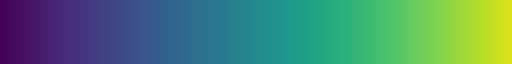

In [2]:
#Import specific colors from Palettable
import matplotlib.colors as colors
from palettable.matplotlib import Viridis_20
cmap = colors.LinearSegmentedColormap.from_list('cmap',[colors.hex2color(c) for c in  Viridis_20.hex_colors[0:-1]])
cmap

### Python Modules and Libraries Used

List of python libraries used, version, and its purpose for the analysis.

| Library    |     Version | Purpose  |
|------------|-------------|----------|
| numpy      |     1.21.5  | array computing with Python|
| pandas     |     1.4.2   | data structures for data analysis and statistics|
| geopandas  |    0.14.1   | geographic pandas extensions|
|matplotlib| 3.5.1| Python plotting package|
|plotly| 5.6.0 |An open-source, interactive data visualization library for Python|


### Data used

List the data sets used in the notebook. Specify sources. Indicate data formats for each input data set. Describe the most relevant columns/variables for the analysis per each input dataset.

| Dataset  |  Format | Source  | Description | Selected/used variables |
|-----------|---------|---------|-------------|------------------------ |
| [Motor Vehicle Collisions](https://data.cityofnewyork.us/browse?q=motor+vehicle) | CSV | [NYC Open Data](https://opendata.cityofnewyork.us/) | Motor Vehicle Collisions in New York, USA | `CRASH DATE`, `CRASH TIME`, `BOROUGH`|
| [Borough Boundaries](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm) | GeoJson | [NYC Open Data](https://opendata.cityofnewyork.us/) | Borough boundaries in NYC | `borough_name`, `geometry` |

## Data Preprocessing

Data preprocessing is the concept of changing the raw data into a clean data set.

First, motor vehicle collisions dataset in New York was obtained in .csv format. Later, the data loaded into the environment was made simple by deleting some columns in order to be used for the purpose of the project.

### Motor Vehicle Collisions Data

In [3]:
#Read the motor vehicle collisions data from .csv file
crash_data = pd.read_csv('motor_vehicle.csv')

#Drop NaN values that LATITUDE column has it in order to create good comparison.
crash_data = crash_data.dropna(subset=["LATITUDE"])

print('Total Number of Reported Motor Vehicle Crashes:', crash_data['COLLISION_ID'].nunique())

C:\Users\User\AppData\Local\Temp\ipykernel_20888\651968441.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  crash_data = pd.read_csv('motor_vehicle.csv')


Total Number of Reported Motor Vehicle Crashes: 1811369


In [5]:
#Convert to CRASH DATE column data type from object to datetime.
crash_data["CRASH DATE"] = pd.to_datetime(crash_data["CRASH DATE"])

#Make new columns regarding pedestrians, cyclist, motorist, and total affected people in order to examine the crash data.
crash_data["TOTAL AFFECTED PERSONS"] = crash_data["NUMBER OF PERSONS INJURED"] + crash_data["NUMBER OF PERSONS KILLED"]
crash_data["TOTAL AFFECTED PEDESTRIANS"] = crash_data["NUMBER OF PEDESTRIANS INJURED"] + crash_data["NUMBER OF PEDESTRIANS KILLED"]
crash_data["TOTAL AFFECTED CYCLIST"] = crash_data["NUMBER OF CYCLIST INJURED"] + crash_data["NUMBER OF CYCLIST KILLED"]
crash_data["TOTAL AFFECTED MOTORIST"] = crash_data["NUMBER OF MOTORIST INJURED"] + crash_data["NUMBER OF MOTORIST KILLED"]

#In order to make clear and understandable, some columns are dropped from the crash_date daatframe.
crash_data = crash_data[["CRASH DATE", "CRASH TIME", "BOROUGH", "ZIP CODE", "LATITUDE", "LONGITUDE", 
                         "TOTAL AFFECTED PERSONS", "TOTAL AFFECTED PEDESTRIANS", "TOTAL AFFECTED CYCLIST",
                         "TOTAL AFFECTED MOTORIST", "CONTRIBUTING FACTOR VEHICLE 1", "COLLISION_ID"]]

crash_data.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,TOTAL AFFECTED PERSONS,TOTAL AFFECTED PEDESTRIANS,TOTAL AFFECTED CYCLIST,TOTAL AFFECTED MOTORIST,CONTRIBUTING FACTOR VEHICLE 1,COLLISION_ID
3,2021-09-11,9:35,BROOKLYN,11208.0,40.667202,-73.866500,0.0,0,0,0,Unspecified,4456314
4,2021-12-14,8:13,BROOKLYN,11233.0,40.683304,-73.917274,0.0,0,0,0,NaN,4486609
6,2021-12-14,17:05,NaN,NaN,40.709183,-73.956825,0.0,0,0,0,Passing Too Closely,4486555
7,2021-12-14,8:17,BRONX,10475.0,40.868160,-73.831480,2.0,0,0,2,Unspecified,4486660
8,2021-12-14,21:10,BROOKLYN,11207.0,40.671720,-73.897100,0.0,0,0,0,Driver Inexperience,4487074


### Motor Crashes Data in NYC by Borough Boundaries

Motor crashes point datasets can be spreaded all over the world outside of New York City, USA. This incorrect result may be caused by some coordinate data not being entered or entered incorrectly. In order to prevent incorrect coordinates, clipping must be done with the "borough_boundaries" data.

In [6]:
#Convert crash_data to geo dataframe 
motor_crashes = gpd.GeoDataFrame(
    crash_data, geometry=gpd.points_from_xy(crash_data.LONGITUDE, crash_data.LATITUDE), crs="EPSG:4326")

# In the table,geometry columns name is changed to location to make it more understandable
motor_crashes = motor_crashes.rename(columns={'geometry': 'Location'}).set_geometry('Location')

In [7]:
# Create a new columns as YEAR and HOUR
motor_crashes["YEAR"] = motor_crashes["CRASH DATE"].apply(lambda dt_: dt_.year)

motor_crashes["CRASH TIME"] = pd.to_datetime(motor_crashes["CRASH TIME"])
motor_crashes["HOUR"] = motor_crashes["CRASH TIME"].dt.hour

In [8]:
#Read the borough boundaries file from GeoJSON format and then rename some important columns to be more understandable.
borough_boundaries = gpd.read_file("https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON")

borough_boundaries = borough_boundaries.rename(columns={"boro_code": "borough_code", "boro_name": "BOROUGH", 
                                                        "shape_area": "area", "geometry": "Location"})

borough_boundaries = borough_boundaries.drop("shape_leng", axis=1).set_geometry("Location")

In [9]:
borough_boundaries.head()

,borough_code,BOROUGH,area,Location
0,5,Staten Island,1623620725.05,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,1,Manhattan,636520502.758,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
2,2,Bronx,1187174772.5,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
3,3,Brooklyn,1934138215.76,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
4,4,Queens,3041418506.64,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


In [10]:
#In order get cleaned and right datasets, the clip method is used for motor_crashes data.
motor_crashes = motor_crashes.clip(borough_boundaries)
motor_crashes.shape

(1798592, 15)

In [11]:
motor_crashes.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,TOTAL AFFECTED PERSONS,TOTAL AFFECTED PEDESTRIANS,TOTAL AFFECTED CYCLIST,TOTAL AFFECTED MOTORIST,CONTRIBUTING FACTOR VEHICLE 1,COLLISION_ID,Location,YEAR,HOUR
134163,2022-05-29,2024-03-19 16:45:00,QUEENS,11691.0,40.594875,-73.739410,0.0,0,0,0,Backing Unsafely,4532423,POINT (-73.73941 40.59488),2022,16
443043,2019-04-10,2024-03-19 21:30:00,QUEENS,11691.0,40.595276,-73.739555,0.0,0,0,0,Passing Too Closely,4112574,POINT (-73.73955 40.59528),2019,21
70574,2021-08-04,2024-03-19 12:30:00,QUEENS,11691.0,40.595592,-73.739624,0.0,0,0,0,Backing Unsafely,4443856,POINT (-73.73962 40.59559),2021,12
140147,2022-06-10,2024-03-19 14:00:00,QUEENS,11691.0,40.595950,-73.739746,0.0,0,0,0,Backing Unsafely,4536789,POINT (-73.73975 40.59595),2022,14
361252,2019-08-29,2024-03-19 13:40:00,QUEENS,11691.0,40.595950,-73.739746,0.0,0,0,0,Failure to Yield Right-of-Way,4197105,POINT (-73.73975 40.59595),2019,13


## Motor Crashes by Year and Time of Day

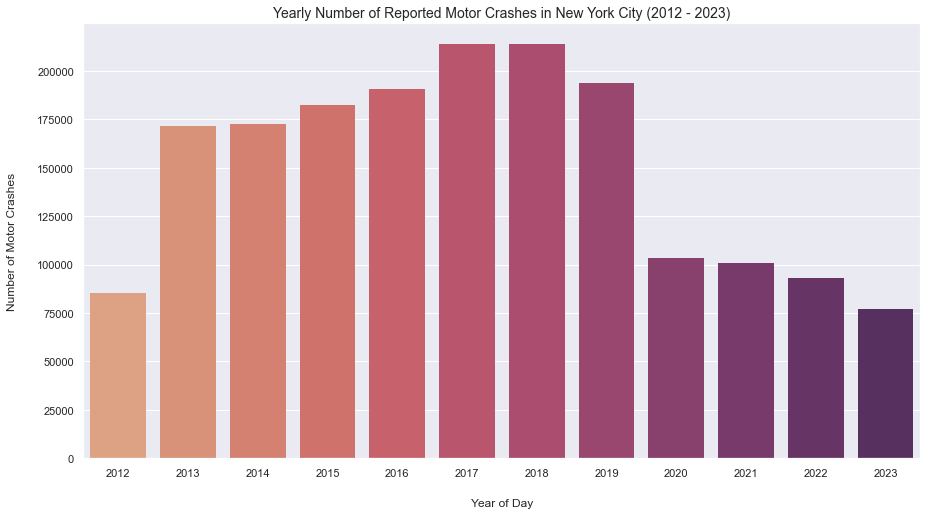

In [37]:
# Style preference as darkgrid for the plots
sns.set_theme(style='darkgrid')

# To plot yearly motor crashes in NYC, USA between 2012 - 2023
plt.figure(figsize=(15,8))
s_year = sns.barplot(data=motor_crashes.groupby('YEAR')['COLLISION_ID'].nunique().reset_index(), x='YEAR', y='COLLISION_ID', palette='flare', linewidth=0)

s_year.set_title('Yearly Number of Reported Motor Crashes in New York City (2012 - 2023)', fontsize=14)
s_year.set_xlabel('Year of Day', fontsize=12, labelpad=20)
s_year.set_ylabel('Number of Motor Crashes', fontsize=12, labelpad=20)

plt.savefig(f"yearly_motor_crashes.jpeg", dpi=500)
plt.show()

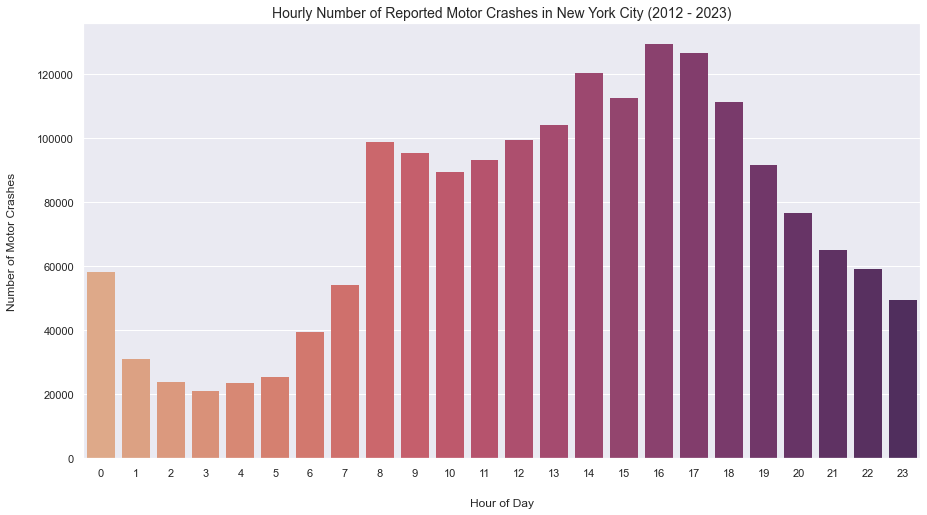

In [36]:
# To plot hourly motor crashes in NYC, USA between 2012 - 2023
plt.figure(figsize=(15,8))
s = sns.barplot(data=motor_crashes.groupby('HOUR')['COLLISION_ID'].nunique().reset_index(), x='HOUR', y='COLLISION_ID', palette='flare', linewidth=0)

s.set_title('Hourly Number of Reported Motor Crashes in New York City (2012 - 2023)', fontsize=14)
s.set_xlabel('Hour of Day', fontsize=12, labelpad=20)
s.set_ylabel('Number of Motor Crashes', fontsize=12, labelpad=20)

plt.savefig(f"hourly_motor_crashes.jpeg", dpi=500)
plt.show()

### Density Heatmap for Motor Crashes

With density heatmap, the time periods, years and hours in which motor accidents occur are obtained. Plotly library was used for this density heatmap analysis. Unlike the two separate static graphs obtained with Seaborn above, it offers an interactive graphic.

In [4]:
import plotly.express as px

In [ ]:
#Make interactive map to show motor crasher using by plotly
fig = px.density_heatmap(motor_crashes, x='YEAR', y='HOUR',
                z='COLLISION_ID',
                marginal_x='histogram',
                marginal_y='histogram')

fig

## Motor Vehicle Collisions in NYC 

When creating a hexagon using by hexbin method, the value 1 was entered into the "mincnt" parameter. One of the reasons for this is to ensure that hexagons with a value of 0 are not found on the map.

C:\Users\User\AppData\Local\Temp\ipykernel_16100\1989603793.py:18: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



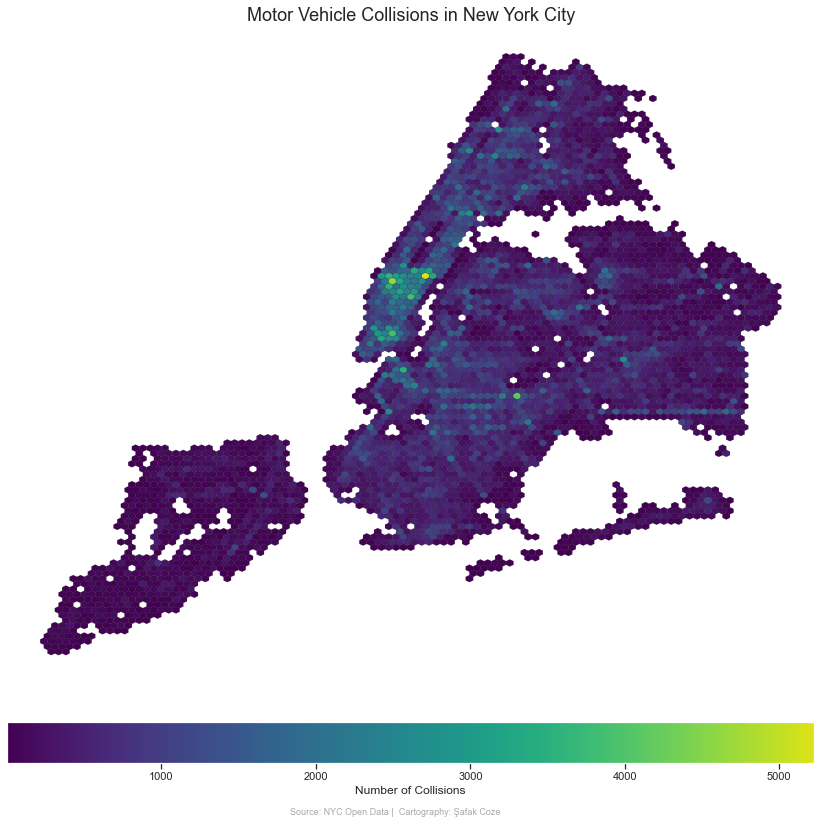

In [28]:
fig, ax = plt.subplots(figsize=(12, 12))

nyc_hex = ax.hexbin(
    motor_crashes['LONGITUDE'], 
    motor_crashes['LATITUDE'],
    mincnt =1,
    gridsize= 100,
    alpha = 1,
    cmap= cmap,
    edgecolors = 'black',
    linewidths = 0.2,
    zorder = 1)

plt.title('Motor Vehicle Collisions in New York City', fontsize=18)
plt.figtext(.5, .05, 'Source: NYC Open Data |  Cartography: Şafak Coze', fontsize=9, 
            ha='center', color="darkgray")

plt.colorbar(nyc_hex, ax=ax, label='Number of Collisions', orientation='horizontal', pad=0.05)
plt.tight_layout()
plt.axis('off')

#In order make map and save this map
plt.savefig(f"Motor_Crashes.jpeg", dpi=500)

In [23]:
# List of columns to calculate sums for
sum_values = ["TOTAL AFFECTED PERSONS", "TOTAL AFFECTED PEDESTRIANS", "TOTAL AFFECTED CYCLIST", "TOTAL AFFECTED MOTORIST"]

# Iterate over the columns and calculate the sums in order to get more information about crashes
for values in sum_values:
    total = motor_crashes[values].sum()
    print(f"Total affected {values.split(' ')[-1].lower()}: {total}")

Total affected persons: 553898.0
Total affected pedestrians: 106571
Total affected cyclist: 50400
Total affected motorist: 390247
